<a href="https://colab.research.google.com/github/ssanchezgoe/prueba-ultracom/blob/master/prueba_CDD_ultracom_ssanchez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Prueba de ingreso ULTRACOM**

**Participante: SEBASTIÁN SÁNCHEZ GÓEZ**

cc 8027598

Datasets necesarios para el desarrollo de la prueba
Dataset Iris:

- https://www.kaggle.com/saurabh00007/iriscsv 

Dataset Crímenes chicago:

- https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2. Debido a que es una cantidad muy grande de datos, tome solo los últimos 3
años de información (2016-2019), puede filtrar directamente desde la fuente


#**Librerías/paquetes necesarias para el desarrollo de la prueba**

In [ ]:
#importemos las librerías necesarias antes
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#**Ejercicio 1**

Con el dataset Iris, implementar varios modelos predictivos (mínimo 3), para predecir la clase de flor a partir de las demás variables que contiene el dataset. Presente un cuadro comparativo con los resultados de cada modelo y diga cuál arroja mejores resultados y explique por qué.

##**Desarrollo**

Proprondremos tres algoritmos de machine learning para realizar la clasificación:

- KNN.
- SVM.
- Arbol de decisiones.

Mediante el algoritmo de `GridSearchCV` se hará una búsqueda de los hiperparámetros que produzcan el mejor modelo en cada caso. Finalmente, para comparar los modelos, usaremos el método de `classification_report()` que contienen varias métricas para medir el comportamiento de los casos en que los algoritmos clasifican mal (Falsos Positivos y Falsos Negativos) como la precisión y la exhaustividad, además del accuracy.

###**Modelo de KNN**

Es el modelo más sencillo que podemos implementar, en donde la clasificación se realiza consultando los K-vecinos más cercanos. Implementemos, además, un `GridSearchCV`, para hacer una búsqueda del hiperparámeto *número de vecinos* más óptimo para la clasificación. `GridSearchCV` aplica, además, un método de validación cruzada, que fijaremos en 5 folds.

Como las clases son balancedas, la métrica de precisión es adecuada. 

In [ ]:
# Separación de datos
X = load_iris().data  
y = load_iris().target

#Ojo con esto
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 44)

tuned_params = [{'n_neighbors':np.arange(1,20)}]

knn_GSCV = GridSearchCV(KNeighborsClassifier(), tuned_params, cv=5, scoring='accuracy')
knn_GSCV.fit(X_train,y_train)

#Mejor número de vecinos:
print("Mejor modelo:", knn_GSCV.best_params_)

Mejor modelo: {'n_neighbors': 5}


En donde vemos que el mejor modelo es un modelo de 5 vecinos. Podemos corroborar esto con una curva de validación: 

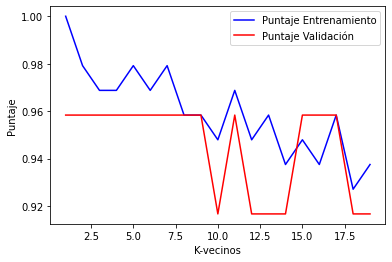

In [ ]:
kn = np.arange(1,20)
train_score, val_score = validation_curve(KNeighborsClassifier(),X_train, y_train, 'n_neighbors', kn, cv=5)

plt.plot(kn, np.median(train_score,1), color = 'blue', label = 'Puntaje Entrenamiento')
plt.plot(kn, np.median(val_score,1), color = 'red', label = 'Puntaje Validación')
plt.legend(loc='best')
plt.xlabel('K-vecinos')
plt.ylabel('Puntaje')
plt.show()

En donde, alrededor de 5 vecinos, se da un buen compromiso sesgo varianza.

Veamos ahora como se comporta nuestro modelo a la hora de clasificar los datos `X_test` que nunca ha visto:

In [ ]:
knn_GSCV.best_estimator_.score(X_test,y_test)

0.9666666666666667

Observamos una precisión bastate alta en nuestro modelo knn con 5 vecinos. Sin embargo, para ser más exactos en el análisis, debemos recurrir a otras métricas como la exahustividad, la precisión, o el f1-score (promedio armónico de la precisión y la exhaustividad). Para hacer esto, recurrimos al método de `classification_report` dentro de las métricas de sklearn.

In [ ]:
print(classification_report(y_test,knn_GSCV.best_estimator_.predict(X_test), target_names=['Setosa','versicolor','virginica']))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00         9
  versicolor       0.90      1.00      0.95         9
   virginica       1.00      0.92      0.96        12

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



Esta tabla es la que usaremos para comprobar el desempeño de los diferentes algorítmos.

###**Modelo de SVM**

Tratemos ahora el problema con máquinas de soporte vectorial para clasificación:

In [ ]:
tuned_params = [{'kernel':['rbf'],'gamma':np.logspace(-4, 2, num=100),'C':np.linspace(1,500,50)}]

svm_GSCV = GridSearchCV(SVC(), tuned_params, cv=5,scoring= 'accuracy')
svm_GSCV.fit(X_train, y_train)

print("Mejor conjunto de parámetros:")
print()
print(svm_GSCV.best_params_)

Mejor conjunto de parámetros:

{'C': 113.02040816326532, 'gamma': 0.002848035868435802, 'kernel': 'rbf'}


In [ ]:
 svm_GSCV.best_estimator_.score(X_test,y_test)

0.9666666666666667

In [ ]:
print(classification_report(y_test,svm_GSCV.best_estimator_.predict(X_test), target_names=['Setosa','versicolor','virginica']))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00         9
  versicolor       0.90      1.00      0.95         9
   virginica       1.00      0.92      0.96        12

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



###**Árboles de decisiones:**

Implementemos ahora un árbol de decisiones para nuestro problema multiclase.

In [ ]:
tuned_params = [{'max_depth':np.arange(1,11), 'max_leaf_nodes':[None,2,3]}]

dt_GSCV = GridSearchCV(DecisionTreeClassifier(), tuned_params)

dt_GSCV.fit(X_train, y_train)

print("Mejor conjunto de parámetros:")
print()
print(dt_GSCV.best_params_)

Mejor conjunto de parámetros:

{'max_depth': 5, 'max_leaf_nodes': None}


In [ ]:
 dt_GSCV.best_estimator_.score(X_test,y_test)

0.8666666666666667

In [ ]:
print(classification_report(y_test,dt_GSCV.best_estimator_.predict(X_test), target_names=['Setosa','versicolor','virginica']))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00         9
  versicolor       0.78      0.78      0.78         9
   virginica       0.83      0.83      0.83        12

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30



###**Conclusión:**

De los reportes de las métricas de clasificación (accuracy, precision, recall y f1-score), concluimos que los mejores dos modelos son:

1. KNN
2. SVM

Ambos quedan empatados en cuanto a métricas, no obstante, considero que KNN es el mejor, porque es un algorítmo computacionalmente "menos" pesado, y la búsqueda del único hiperparámetro es mucho más sencilla que en el caso de una SVM con kernel RBF. En este caso, el factor decisivo para escoger el modelo es la sencillez y costo computacional bajo del knn.

Cabe resaltar que en el modelo de SVM, he optado por un `kernel` de funciones radiales `RBF`, ya que es capaz de resolver problemas generales de fronteras no lineales.

#**Ejercicio 2:**

Realizar un reporte estadístico básico del dataset Iris, usar gráficas e información necesaria para conocer el comportamiento de las diferentes variables.

El dataset propuesto se encuentra en la librería `python` de `sklearn`. Por tal motivo, tomaré el dataset de dicha librería.

El dataset contiene solo datos numéricos (incluida la variable objetivo, que está codificada cardinalmente); presentaré antes los datos en un dataframe de `pandas` con las clases como una variable categórica:

In [ ]:
col_names = ["sepal_length", "sepal_with", "petal_length", "petal_with", "iris_specie"]

df_iris = pd.DataFrame(np.concatenate((load_iris().data,load_iris().target.reshape(-1,1)), axis=1), columns=col_names)
df_iris.iris_specie = df_iris.iris_specie.map({0:'setosa',1:'versicolor',2:'virginica'})

# 10 instancias aleatorias dataframe 
df_iris.sample(10)

,sepal_length,sepal_with,petal_length,petal_with,iris_specie
18,5.7,3.8,1.7,0.3,setosa
11,4.8,3.4,1.6,0.2,setosa
80,5.5,2.4,3.8,1.1,versicolor
92,5.8,2.6,4.0,1.2,versicolor
15,5.7,4.4,1.5,0.4,setosa
140,6.7,3.1,5.6,2.4,virginica
106,4.9,2.5,4.5,1.7,virginica
131,7.9,3.8,6.4,2.0,virginica
86,6.7,3.1,4.7,1.5,versicolor
121,5.6,2.8,4.9,2.0,virginica


La vista anterior representa una posible versión del dataset original, sin codificar la variable target. 

##**Distribución de las especies de flor Iris**

Veamos si las clases a predecir están balanceadas

In [ ]:
df_iris.iris_specie.value_counts()

setosa        50
versicolor    50
virginica     50
Name: iris_specie, dtype: int64

En donde se observa que las clases se encuentran perfectamente balanceadas, lo cual nos sirve para validar la métrica de accuracy como una metríca adecuada. En el caso de clases desbalanceadas, es mejor recurrir a otras métricas como la exhaustividad o la precisión.

Esta distribuciones de especies de flor iris, podemos visualizarla mejor mediante una gráfica de torta:



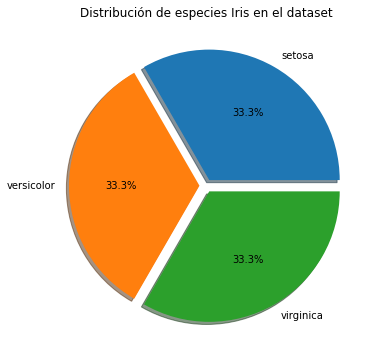

In [ ]:
df_iris.iris_specie.value_counts().plot(kind='pie', label = '', explode=[0.05,0.05,0.05], autopct='%1.1f%%', shadow=True, figsize=(8,6))
plt.title("Distribución de especies Iris en el dataset")
plt.show()

Relicemos un resumen estadístico de  medidas de tendencias centrales y percentiles mediante el método `describe()`:

In [ ]:
df_iris.describe(include='all')

,sepal_length,sepal_with,petal_length,petal_with,iris_specie
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,setosa
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.057333,3.758000,1.199333,NaN
std,0.828066,0.435866,1.765298,0.762238,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN


Como era de esperarse para la variable objetivo, la cual es categórica, las medidas de tendencia central y percentiles son `NaN`. Por otra parte, nos indica que la especie setosa es el top de cuentas con 50, no obstante, al ser 3 clases y 150 datos, todas las clases tienen 50 ejemplos.

Esta tabla también puede asimilarse a través de diagramas de cajas y bigotes o diagramas de violín; este ultimo diagráma, corresponde a la conjunción de dos métodos:

- Histogramas
- Box plots

Este tipo de gráficas (cajas y violines) se usan para ver la distribución de las variables númericas en relación a las variable objetivo categórica de especie de flor iris. Al ser tres categorías, se tendrán tres grupos de distribuciones por gráfica; al ser 4 características, no

##**Cajas y bigotes**

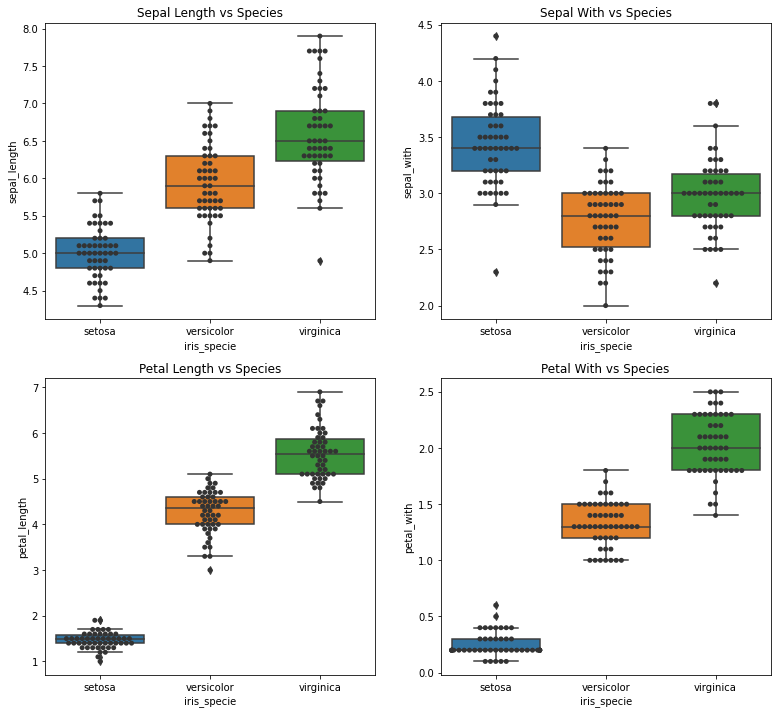

In [ ]:
plt.figure(figsize=(13,12))

plt.subplot(2,2,1)
sns.boxplot(x="iris_specie", y="sepal_length", data=df_iris)
sns.swarmplot(x="iris_specie", y="sepal_length", data=df_iris, color='0.2')
plt.title("Sepal Length vs Species")

plt.subplot(2,2,2)
sns.boxplot(x="iris_specie", y="sepal_with", data=df_iris)
sns.swarmplot(x="iris_specie", y="sepal_with", data=df_iris, color='0.2')
plt.title("Sepal With vs Species")

plt.subplot(2,2,3)
sns.boxplot(x="iris_specie", y="petal_length", data=df_iris)
sns.swarmplot(x="iris_specie", y="petal_length", data=df_iris, color = '0.2')
plt.title("Petal Length vs Species")

plt.subplot(2,2,4)
sns.boxplot(x="iris_specie", y="petal_with", data=df_iris)
sns.swarmplot(x="iris_specie", y="petal_with", data=df_iris, color = '0.2')
plt.title("Petal With vs Species")

plt.show()

Podemos ver como las características relacionadas con el pétalo, son las que permiten diferenciar mejor los tres tipos de especies de flor iris.

##**Gráficas de violines**

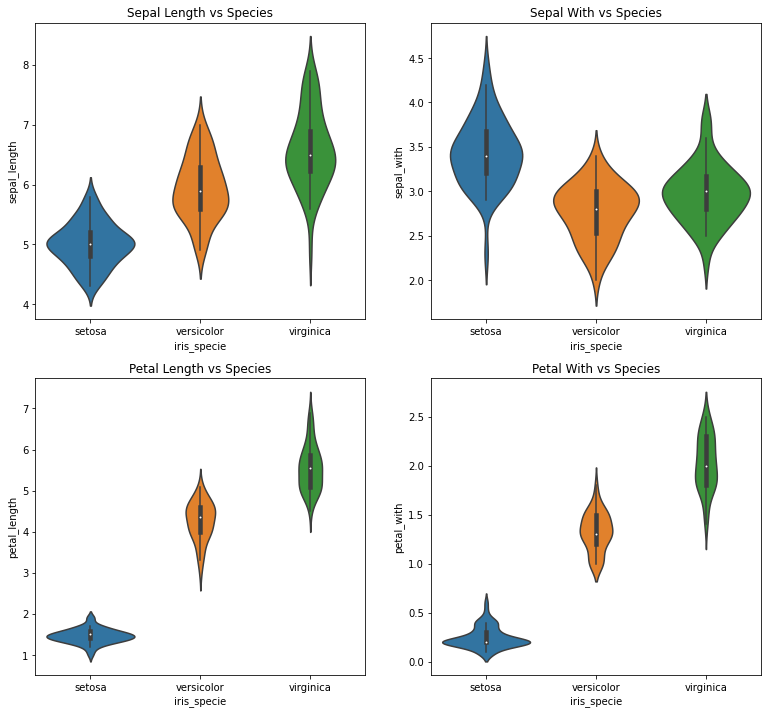

In [ ]:
plt.figure(figsize=(13,12))

plt.subplot(2,2,1)
sns.violinplot(x="iris_specie", y="sepal_length", data=df_iris)
plt.title("Sepal Length vs Species")
plt.subplot(2,2,2)
sns.violinplot(x="iris_specie", y="sepal_with", data=df_iris)
plt.title("Sepal With vs Species")
plt.subplot(2,2,3)
sns.violinplot(x="iris_specie", y="petal_length", data=df_iris)
plt.title("Petal Length vs Species")
plt.subplot(2,2,4)
sns.violinplot(x="iris_specie", y="petal_with", data=df_iris)
plt.title("Petal With vs Species")
plt.show()

Empezamos a intuir entonces que las carácteristicas del conjunto de datos *Petal Lenght* y *Petal With* se encuentra correlacionadas con las especies de flores iris, por lo que serían características adecuadas para distinguirlas. 

##**Gráficas por parejas**

Podemos confirmar, visualmente, que la características asociadas al pétalo son las que mejor ayudan a diferenciar las clases de especies mediante las gráficas por parejas `pairplot` de la librería de `seaborn`:

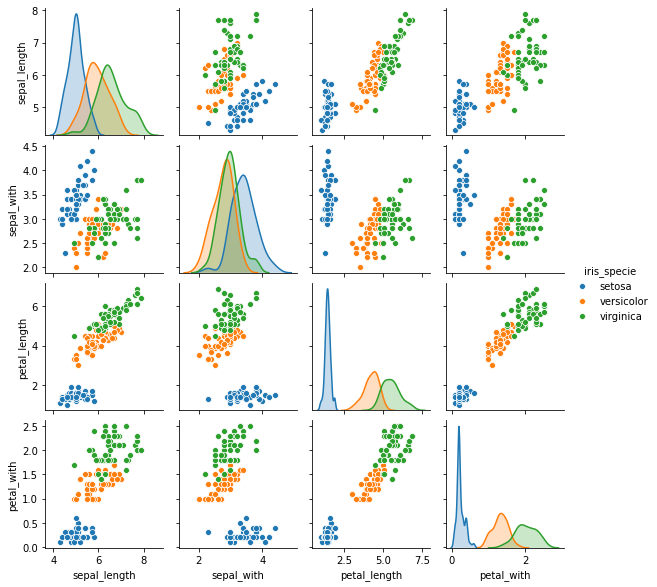

In [ ]:
sns.pairplot(df_iris, hue="iris_specie", height=2)
plt.show()

Estas gráficas ilustran nuestra intuición inicial. En ellas vemos como, si quisieramos construir un modelo de dos variables para clasificar las especies de la flor iris, las dos mejores características serían *petal_width* y *petal_length*. 

Centrándonos en las gráficas `(petal_width, petal_length)`, o la gráfica equivalente `(petal_length,petal_width)`, vemos que son las características que ayudan a distinguir mejor los grupos de especies:

- setosa
- versicolor
- virginica

Tambíen se pueden corroborar la potencialidad de estas dos características (`petal_lenght` y `petal_width`), a través del los histogramas (dos últimas gráficas de la diagonal), en donde los histogramas por especies se encuentran mejor diferenciados, en relación a los histogramas por especie de las características relacionadas con el sépalo, los cuales se encuentran más solapados.

##**Análisis de correlaciones**

Hasta el momento, todo el análisis de las características del dataset Iris lo hemos realizado de forma visual. Podemos calcular la correlacion de las diferentes características con la variable objetivo. Para ello, usaremos la codificación numerica de la variable objetivo.

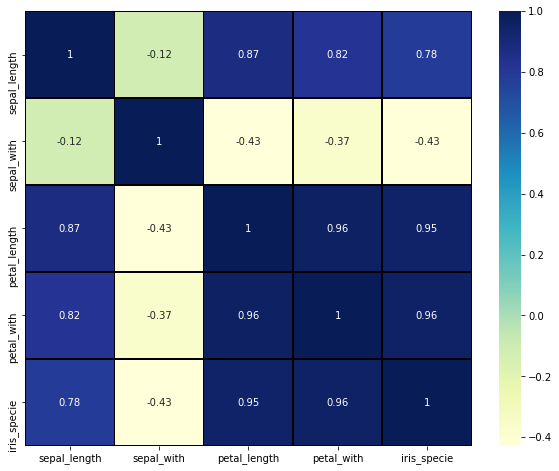

In [ ]:
df_iris['iris_specie'] = load_iris().target
plt.figure(figsize=(10,8))
sns.heatmap(df_iris.corr(), cmap = 'YlGnBu', annot = True, linewidths=0.5, linecolor='k')
plt.show()

Centrándonos en el recuadro azul de la parte inferior derecha, vemos que las características `petal_length` y `petal_with` son las que tienen una correlación más fuerte con la variable objetivo de especie de flor iris, como habíamos intuido.



#**Ejercicio 3:**

Realizar un análisis descriptivo al dataset de crímenes de chicago, se debe dar información
que usted considere importante mostrar de acuerdo con las variables con las que cuenta.
Algunos ejemplos son:
1. Cantidad de crímenes mensuales efectuados por tipo
2. Clasificar los conteos anteriores en cuantos tuvieron arrestos y cuantos no.
3. Clasificar los 22 distritos en tres categorías (Alta, Media y Baja), de acuerdo con el
índice de criminalidad respecto al resto de la ciudad.

##**Desarrollo**

Empecemos por cargar los datos almacenados en mi drive de google

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Carga de datos**

Cargemos los datos almacenados en una tabla csv

**Nota:** Los datos fueron descargados previamente de la página en un rango temporal de 2016 a 2019. 

In [ ]:
dfc_16_19_original = pd.read_csv('/content/drive/My Drive/chicago_crimes_dataset/crimes_2016_to_2019.csv')

Trabajemos mejor con una copía del dataset:

In [ ]:
#Copia del dataset original
dfc_16_19 = dfc_16_19_original.copy()

###**Inspección de la tabla y preprocesado**

Visualicemos algunas instancias del dataset 

In [ ]:
dfc_16_19.sample(10)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
495901,11136382,JA494459,11/01/2017 01:00:00 PM,052XX W CRYSTAL ST,0810,THEFT,OVER $500,STREET,False,False,2532,25.0,37.0,25,06,1141240.0,1907824.0,2017,02/10/2018 03:50:01 PM,41.903146,-87.756641,"(41.903146051, -87.756641346)"
852964,11625922,JC185669,03/14/2019 06:42:00 PM,074XX N PAULINA ST,0460,BATTERY,SIMPLE,RESIDENCE,False,False,2422,24.0,49.0,1,08B,1163827.0,1949311.0,2019,08/17/2019 03:57:45 PM,42.016542,-87.672499,"(42.016541612, -87.672499325)"
353127,10930404,JA245872,05/01/2017 05:20:00 AM,032XX S ARCHER AVE,0860,THEFT,RETAIL THEFT,GAS STATION,False,False,912,9.0,11.0,59,06,1164849.0,1883051.0,2017,02/10/2018 03:50:01 PM,41.834699,-87.670623,"(41.834698514, -87.670623045)"
797147,11546478,JB567157,12/18/2018 04:00:00 PM,052XX W SCHUBERT AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,2514,25.0,31.0,19,26,1141019.0,1917455.0,2018,12/28/2018 04:06:47 PM,41.929579,-87.757215,"(41.929578643, -87.757215488)"
388031,10983111,JA308184,06/15/2017 03:13:00 PM,069XX S DR MARTIN LUTHER KING JR DR,041A,BATTERY,AGGRAVATED: HANDGUN,ALLEY,False,False,322,3.0,6.0,69,04B,1180119.0,1859008.0,2017,02/10/2018 03:50:01 PM,41.768385,-87.615331,"(41.768385479, -87.615330597)"
504145,11153199,JA517121,11/12/2017 10:00:00 PM,023XX N PARKSIDE AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,2515,25.0,37.0,19,07,1138329.0,1914939.0,2017,02/10/2018 03:50:01 PM,41.922724,-87.767162,"(41.922723637, -87.767161674)"
281153,10819681,JA120141,01/17/2017 11:36:00 PM,043XX S ST LOUIS AVE,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE-GARAGE,False,False,821,8.0,14.0,58,05,1153794.0,1875609.0,2017,02/10/2018 03:50:01 PM,41.814504,-87.711385,"(41.814503577, -87.7113848)"
521340,11184983,JA559122,12/06/2017 06:14:00 PM,014XX S KOMENSKY AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,1011,10.0,24.0,29,06,1149617.0,1892762.0,2017,02/10/2018 03:50:01 PM,41.861656,-87.726262,"(41.861655606, -87.726262003)"
82031,10504536,HZ245499,04/30/2016 12:31:00 AM,013XX E 87TH ST,031A,ROBBERY,ARMED: HANDGUN,RESTAURANT,False,False,412,4.0,8.0,48,03,1186818.0,1847569.0,2016,02/10/2018 03:50:01 PM,41.736840,-87.591138,"(41.736839681, -87.591137533)"
419480,11029961,JA362224,07/25/2017 03:19:00 AM,011XX W WEBSTER AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,BAR OR TAVERN,False,False,1811,18.0,32.0,7,14,1168513.0,1914783.0,2017,02/10/2018 03:50:01 PM,41.921695,-87.656260,"(41.921695147, -87.656260317)"


####**Tratamiento Columnas**

Por comodidad a la hora de acceder a las diferentes columnas del dataset, quitemos los espacios en los nombres de las columnas:

In [ ]:
dfc_16_19.rename(columns=lambda x: x.replace(" ",""), inplace=True)
dfc_16_19.head(10)

,ID,CaseNumber,Date,Block,IUCR,PrimaryType,Description,LocationDescription,Arrest,Domestic,Beat,District,Ward,CommunityArea,FBICode,XCoordinate,YCoordinate,Year,UpdatedOn,Latitude,Longitude,Location
0,11919934,JC544657,01/01/2016 12:00:00 AM,016XX S MORGAN ST,1754,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,RESIDENCE,True,True,1235,12.0,25.0,31,02,1170144.0,1892108.0,2016,08/18/2020 03:51:25 PM,41.859438,-87.650930,"(41.859437966, -87.650930214)"
1,12133496,JD329940,01/01/2016 12:00:00 AM,057XX W ROOSEVELT RD,1562,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,HOSPITAL BUILDING / GROUNDS,False,False,1513,15.0,29.0,25,17,NaN,NaN,2016,08/13/2020 03:48:16 PM,NaN,NaN,NaN
2,11951372,JD115579,01/01/2016 12:00:00 AM,041XX W CULLOM AVE,1562,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,APARTMENT,False,True,1722,10.0,39.0,16,17,1149087.0,1890100.0,2016,05/07/2020 03:45:36 PM,41.854361,-87.728276,"(41.854361018, -87.728276419)"
3,11340701,JB297407,01/01/2016 12:00:00 AM,032XX N KEATING AVE,1751,OFFENSE INVOLVING CHILDREN,CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,False,True,1731,17.0,30.0,15,17,1147835.0,1921394.0,2016,04/20/2020 03:47:53 PM,41.940259,-87.732067,"(41.940259199, -87.732066833)"
4,11958087,JD122201,01/01/2016 12:00:00 AM,032XX W 64TH PL,0266,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,False,823,8.0,17.0,66,02,1155923.0,1861672.0,2016,03/05/2020 03:50:35 PM,41.776216,-87.703950,"(41.776215942, -87.703949602)"
5,11958092,JD122276,01/01/2016 12:00:00 AM,048XX W HUBBARD ST,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,RESIDENCE,False,True,1532,15.0,28.0,25,17,NaN,NaN,2016,02/26/2020 03:46:52 PM,NaN,NaN,NaN
6,11924721,JC549590,01/01/2016 12:00:00 AM,054XX W ADDISON ST,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,APARTMENT,True,True,1633,16.0,36.0,15,02,1139249.0,1923398.0,2016,01/22/2020 03:50:17 PM,41.945919,-87.763575,"(41.945919295, -87.763574687)"
7,11877168,JC492397,01/01/2016 12:00:00 AM,054XX W ADDISON ST,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,APARTMENT,True,True,1633,16.0,36.0,15,02,1139249.0,1923398.0,2016,01/22/2020 03:50:17 PM,41.945919,-87.763575,"(41.945919295, -87.763574687)"
8,11898856,JC519613,01/01/2016 12:00:00 AM,018XX N KILDARE AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,True,2534,25.0,35.0,20,17,NaN,NaN,2016,12/14/2019 03:48:22 PM,NaN,NaN,NaN
9,11911256,JC534410,01/01/2016 12:00:00 AM,007XX W 31ST ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,False,False,914,9.0,11.0,60,11,NaN,NaN,2016,12/05/2019 03:56:41 PM,NaN,NaN,NaN


Veamos el tipo de la columna `Date`

In [ ]:
dfc_16_19.Date.dtypes

dtype('O')

Analicemos bien el formato temporal en el que está expresado nuestra columna `Date`:

In [ ]:
dfc_16_19.Date.sample(10)

37366     02/26/2016 09:15:00 PM
354589    05/03/2017 01:00:00 AM
982820    09/02/2019 03:00:00 AM
786080    12/03/2018 11:40:00 AM
681668    07/18/2018 07:00:00 PM
740792    09/30/2018 11:20:00 PM
527362    12/15/2017 12:00:00 PM
927629    06/24/2019 05:00:00 PM
923449    06/19/2019 11:00:00 AM
463208    09/18/2017 10:00:00 PM
Name: Date, dtype: object

Vemos entonces que el formato es `mes/dia/año AM-PM`. Este formato podemos pasárselo directamente a la función `to_datetime()` de pandas. Veamos dos ejemplos

In [ ]:
print("02/25/2019 10:00:00 PM to_datetime: ",pd.to_datetime("02/25/2019 10:00:00 PM"))
print("06/11/2016 12:00:00 AM to_datetime: ",pd.to_datetime("06/11/2016 12:00:00 AM"))

02/25/2019 10:00:00 PM to_datetime:  2019-02-25 22:00:00
06/11/2016 12:00:00 AM to_datetime:  2016-06-11 00:00:00


Convirtamos entonces este formato de string para la fecha a datetime:

In [ ]:
dfc_16_19.Date  = pd.to_datetime(dfc_16_19.Date)

La columna `Date` ha sido convertida a un formato temporal; de esta forma podremos operar más fácilmente en los diferentes análisis. 

Corroboremos que, efectivamente, hemos extraidos los datos entre los años 2016 y 2019:

In [ ]:
dfc_16_19.Date.describe()

count                 1065825
unique                 480672
top       2016-01-01 00:01:00
freq                      166
first     2016-01-01 00:00:00
last      2019-12-31 12:00:00
Name: Date, dtype: object

Efectivamente, la primera fecha es el 1 de enero de 2016 y la última del 2019.

####**Tratamiento Datos faltantes**

Analicemos los datos faltantes de la tabla de crímenes en Chicago:

In [ ]:
dfc_16_19.isna().sum()

ID                         0
CaseNumber                 0
Date                       0
Block                      0
IUCR                       0
PrimaryType                0
Description                0
LocationDescription     4501
Arrest                     0
Domestic                   0
Beat                       0
District                   1
Ward                      20
CommunityArea              0
FBICode                    0
XCoordinate            11805
YCoordinate            11805
Year                       0
UpdatedOn                  0
Latitude               11805
Longitude              11805
Location               11805
dtype: int64

La mayoría de datos faltantes hace parte de características de localización geográfica del crimen. Estos valores de localización no pueden ser inferidos mediante algún otro tipo de algoritmo (tratándolo como un problema de clasificación no supervisado, por ejempo), eliminaremos el total de los datos faltantes. Además, dichos datos se basan, en muchas ocaciones, en declaraciones imprecisas de testigos de localizaciones de escenas de crimen. 

In [ ]:
dfc_16_19.dropna(inplace=True)
dfc_16_19.reset_index(inplace=True)

El porcentaje de datos que hemos eliminado es

In [ ]:
100-100*len(dfc_16_19)/len(dfc_16_19_original)

1.4091431520183875

el cual es pequeño.

####**Análisis Descriptivo**



#####**1. Analisis por año, mes, semana y día del total de crímenes:**

Empecemos por realizar una pequeña modificación a la tabla `dfc_16_09`:

1. Guardemos otra copia en `dfc2_16_19`. 
2. Fijemos la fecha como índice.
3. Agregemos una columna de 1s (que será usada con fines de conteos por agrupación).
4. Hagamos un conteo de crímenes por año, mes, semana y dias, para lo que usamos el método `resample()`

In [ ]:
#Tratamiento de los datos
dfc2_16_19 = dfc_16_19.copy()
dfc2_16_19.set_index('Date', inplace=True)
dfc2_16_19['conteo'] = 1

######**Crímenes por años**

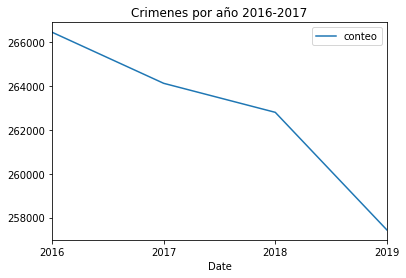

In [ ]:
dfc2_16_19[['conteo']].resample('A').sum().plot()
plt.title("Crimenes por año 2016-2017")
plt.show()

**Conclusión:** De esta gráfica podomos concluir que los crímenes han disminuido lévemente pasando de, aproximadamente, 266000 casos en 2016 a un ppoco menos de 258000 casos en 2017.

######**Crímenes por mes**

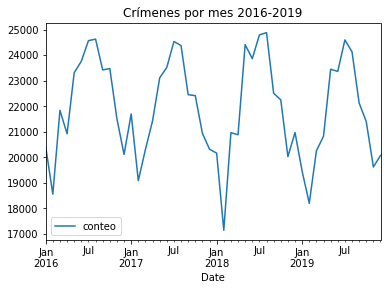

In [ ]:
dfc2_16_19[['conteo']].resample('M').sum().plot()
plt.title("Crímenes por mes 2016-2019")
plt.show()

In [ ]:
dfc2_16_19[['conteo']].resample('M').sum().sort_values(by = 'conteo', ascending=False).iloc[:10]

,conteo
Date,
2018-08-31,24877
2018-07-31,24788
2016-08-31,24623
2019-07-31,24593
2016-07-31,24563
2017-07-31,24531
2018-05-31,24409
2017-08-31,24371
2019-08-31,24128


**Conclusión:**

De los crímenes por meses, vemos que existe cierta estacionalidad, en donde los meses de verano (Julio y Agosto), son los meses en donde se comenten más crímenes. 

######**Crímenes por semana**

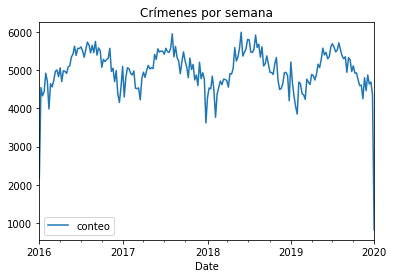

In [ ]:
dfc2_16_19[['conteo']].resample('W').sum().plot()
plt.title("Crímenes por semana")
plt.show()

In [ ]:
dfc2_16_19[['conteo']].resample('M').sum().sort_values(by = 'conteo', ascending=False).iloc[:10]

,conteo
Date,
2018-08-31,24877
2018-07-31,24788
2016-08-31,24623
2019-07-31,24593
2016-07-31,24563
2017-07-31,24531
2018-05-31,24409
2017-08-31,24371
2019-08-31,24128


**Conclusión:** Vemos que estos datos semanales, se corresponden con los datos mensuales, y presentan estacionalidad. Se identifica también repuntes de los crímenes en los meses señalados en el análisis mensual.

######**Crímenes por día**

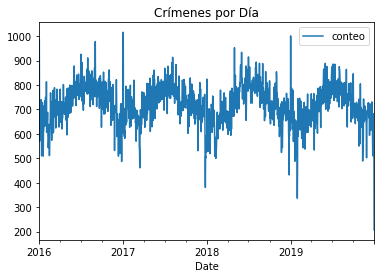

In [ ]:
dfc2_16_19[['conteo']].resample('D').sum().plot()
plt.title("Crímenes por Día")
plt.show()

**Conclusión:** Se puede observar el comportamiento estacional de los crímenes diarios, corroborado en los crímenes por semana y por mes.

######**Crímenes por día**

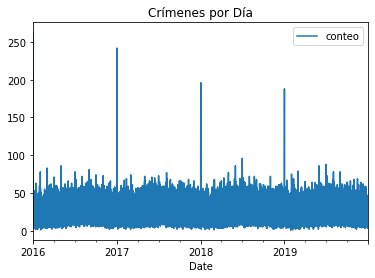

In [ ]:
dfc2_16_19[['conteo']].resample('H').sum().plot()
plt.title("Crímenes por Día")
plt.show()

Esta gráfica resulta sumamente interesante, ya que se observan unos picos con cierta frecuencia. Intentemos hallarlos:

In [ ]:
dfc2_16_19[['conteo']].resample('D').sum().sort_values(by = 'conteo', ascending=False).iloc[:4]

,conteo
Date,
2017-01-01,1016
2019-01-01,1001
2016-01-01,986
2016-09-01,978


**Conclusión:** Los primeros días de cada año se aumentan los crímenes en la ciudad de chicago!

#####**2. Lugar más peligroso de Chicago entre 2016-2019**

Este dataset nos permite determinar, por ejemplo, el lugar dónde ocurren más crímenes en la ciudad de Chicago en un periodo de 4 años. Para ello, recurrimos a la variable `Block` la cual indica la dirección parcialmente redactada de dónde ocurrió el incidente.

Mediante el método `describe`, aplicado a la columna `Block`, podemos hallar el lugar donde se comenten más crimienes en Chicago:

In [ ]:
dfc2_16_19.Block.describe()

count              1050806
unique               33131
top       001XX N STATE ST
freq                  3801
Name: Block, dtype: object

Ubiquemos en un mapa este lugar. Para ello debemos filtrar la localización de este bloque:

In [ ]:
print("Distrito de alta criminalidad: ", dfc2_16_19[dfc2_16_19.Block=='001XX N STATE ST']['District'].iloc[0])
print("Latitud y longitud zona de alta criminalidad: ", dfc2_16_19[dfc2_16_19.Block=='001XX N STATE ST']['Location'].iloc[0])

Distrito de alta criminalidad:  1.0
Latitud y longitud zona de alta criminalidad:  (41.883500187, -87.627876698)


Una vez halladas las coordenadas de longitud y latitud, podemos ubicar en el mapa dicha zona.

Creemos en folium, con un marcador en esta zona, con un tag de advertencia:

In [ ]:
# Cargar Mapa de Chicago
mapa_chicago = folium.Map(location=[41.864973,-87.706819], zoom_start = 11, tiles='cartodbdark_matter')

# Creación de tag
tag = """<p style="color:red">ZONA DE ALTA CRIMINALIDAD</p><br>
                              Distrito = {}<br>
                              Crimenes 2016-2019 = {}"""
tag = tag.format(1,3801)
tag = folium.Html(tag, script=True)
popup = folium.Popup(tag, max_width=300)
icon = folium.Icon(color='red')

# Inserción del tag en el mapa
folium.CircleMarker(location = [41.883500187, -87.627876698], popup=popup, fill = True).add_to(mapa_chicago)
mapa_chicago

Este es un overview muy amplio, que proviene de un conteo realizado en 4 años. Podríamos analizar, por ejemplo, si la criminalidad se redujo entre los diferentes años, haciendo un conteo por año, mes, semana, hora. 

#####**3. Mapa localización de los crímenes más comunes por distrito**

A continuación, agrupemos nuestro dataset por distrito (District) y extraigamos las coordenadas de latitud, longitud, así como las características de arresto (Arrest), descripción del lugar (LocationDescription) y tipo de crimen (PrimaryType). 

Después de agrupar, calculemos los valores más comunes en cada una de las características agrupadas por distrito, excepto en la latitud y la longitud, en las cuales extraemos el primer valor.

In [ ]:
mapa_chicago2 = folium.Map(location=[41.864973,-87.706819], tiles='cartodbdark_matter')

In [ ]:
#Agrupemos por Distrito 
ubicaciones = dfc_16_19.groupby('District')['Latitude', 'Longitude', 'Arrest', 'LocationDescription','PrimaryType']
ubicaciones = ubicaciones.agg({'Latitude':'first', 'Longitude':'first', 'Arrest':lambda x:x.value_counts().index[0], 'LocationDescription':lambda x:x.value_counts().index[0], 'PrimaryType':lambda x:x.value_counts().index[0]}) 
ubicaciones

# Mapeamos los valores de arresto para presentarlos mejor escritos en el tag
ubicaciones.Arrest = ubicaciones.Arrest.map({True:'Si', False:'No'})

#Nos quedamos solo con las siguientes características para mostrar en el tag
ubicaciones2 = ubicaciones.loc[:, ['Latitude', 'Longitude', 'Arrest', 'LocationDescription','PrimaryType']]
ubicaciones2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Latitude,Longitude,Arrest,LocationDescription,PrimaryType
District,,,,,
1.0,41.886013,-87.629505,No,RESTAURANT,THEFT
2.0,41.819124,-87.602250,No,STREET,THEFT
3.0,41.784902,-87.612066,No,APARTMENT,BATTERY
4.0,41.731368,-87.549897,No,RESIDENCE,BATTERY
5.0,41.717303,-87.628562,No,RESIDENCE,BATTERY
6.0,41.746000,-87.618013,No,STREET,BATTERY
7.0,41.768293,-87.650559,No,RESIDENCE,BATTERY
8.0,41.776216,-87.703950,No,RESIDENCE,THEFT
9.0,41.795290,-87.641145,No,STREET,BATTERY


In [ ]:
for i in range(len(ubicaciones2)):
    lat = ubicaciones2.iloc[i][0]
    long = ubicaciones2.iloc[i][1]
    
    tag = """ID_Community: {}<br>
                Arresto: {}<br>
                Tipo de lugar: {}<br>
                Tipo de Crimen: {}<br>"""
    tag = tag.format(ubicaciones2.index[i], ubicaciones2.iloc[i][2], ubicaciones2.iloc[i][3], ubicaciones2.iloc[i][4])
    folium.CircleMarker(location = [lat, long], popup= tag, fill = True).add_to(mapa_chicago2)

mapa_chicago2

Este mapa es bastante ilustrativo ya que nos brinda la siguiente información por distrito:

- Ubicación de los distritos
- Determinación de si, en su mayoría, los criminales fueron arrestados o no al cometer el crimen.
- El tipo de lugar más frecuente en el que se cometieron los crímenes.
- El tipo de crimen cometido con mayor frecuencia.

#####**4. Cantidad de crímenes mensuales efectuados por tipo**

En la pregunta no se especifica si la cantidad de crímenes mensuales debe ser por año o no, por ende, desarrollemos dos casos de crímenes contados:
- Por mes y tipo, sumando todos los años.
- Por año, por mes y tipo (en donde se sumarían los crimenes por cada mes para cada uno de los años). 

Para este punto, realizaremos dos cosas:

1. Realizar una gráfica de barras. 
2. Realizar una tabla pivote para ver los valores consignados por mes y tipo de crimen.

<p><a name="yr_mes_tipo"></a></p>

######**4.1. Por año, mes y tipo**

Como uno puede agrupar en una tabla segun lo que deseemos, usemos `DatetimePropierties` para agrupar por años y meses, de la forma


In [ ]:
dfc_16_19.Date.dt.year

0          2016
1          2016
2          2016
3          2016
4          2016
           ... 
1050801    2019
1050802    2019
1050803    2019
1050804    2019
1050805    2019
Name: Date, Length: 1050806, dtype: int64

In [ ]:
dfc_16_19.Date.dt.month

0           1
1           1
2           1
3           1
4           1
           ..
1050801    12
1050802    12
1050803    12
1050804    12
1050805    12
Name: Date, Length: 1050806, dtype: int64

Nótese que las dos series anteriores corresponde el año y el mes de cada una de las entradas de la columna `Date`, por lo que tienen la misma longitud que la tabla a lo largo de las filas

In [ ]:
len(dfc_16_19.Date.dt.month)==len(dfc_16_19)

True

Por tal motivo, podemos agrupar de acuerdo a sus valores de la siguiente forma:

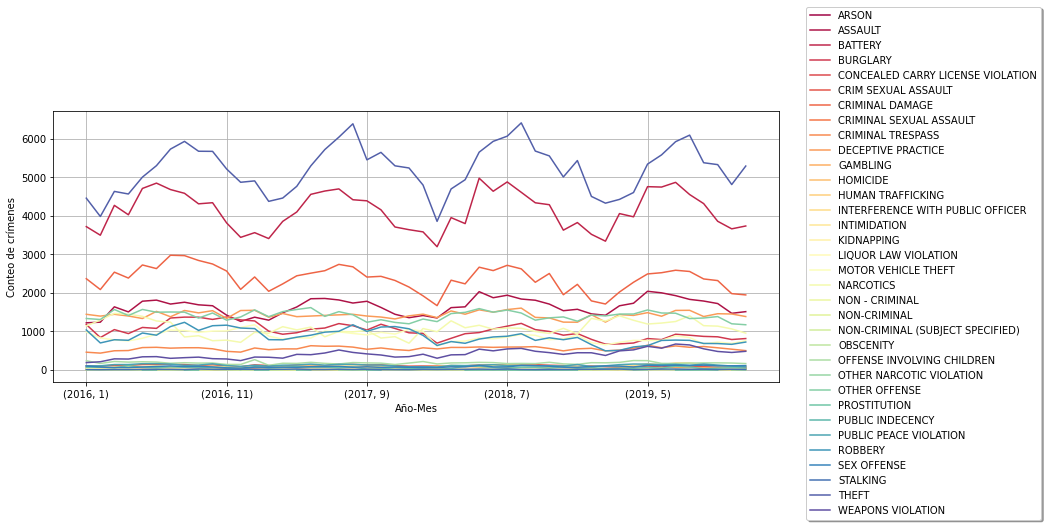

In [ ]:
# Agrupación con gráfica
df_grouped = dfc_16_19.groupby([dfc_16_19.Date.dt.year,dfc_16_19.Date.dt.month, 'PrimaryType']).ID.count()
df_grouped.unstack().plot(colormap='Spectral', grid=True, figsize=(13,5))
plt.legend(loc="upper center", bbox_to_anchor=(1.2,1.4), shadow=True, ncol=1)
plt.xlabel("Año-Mes")
plt.ylabel("Conteo de crímenes")
plt.show()

Podemos advertir una estacionalidad en los crimenes, o comportamiento ondulatorio. Vemos pues, que en los meses 7 y 8 (Julio y  Agosto) de cada año hay un repunte en todos los tipos de crímenes. En una tabla, podemos hacer este conteo, para cada uno de los tipos de crímenes, de la siguiente forma:

In [ ]:
dfc_16_19.groupby([dfc_16_19.Date.dt.year, dfc_16_19.Date.dt.month, 'PrimaryType'])['ID'].aggregate('count').unstack().fillna(0)

PrimaryType  ARSON  ASSAULT  BATTERY  ...  STALKING   THEFT  WEAPONS VIOLATION
Date Date                             ...                                     
2016 1        42.0   1224.0   3720.0  ...       9.0  4458.0              192.0
     2        31.0   1241.0   3497.0  ...       7.0  3983.0              214.0
     3        41.0   1639.0   4271.0  ...      10.0  4633.0              289.0
     4        46.0   1507.0   4027.0  ...      10.0  4566.0              284.0
     5        55.0   1785.0   4710.0  ...      14.0  5004.0              342.0
     6        41.0   1813.0   4848.0  ...      18.0  5301.0              347.0
     7        47.0   1711.0   4681.0  ...      16.0  5731.0              303.0
     8        45.0   1758.0   4584.0  ...      11.0  5931.0              320.0
     9        45.0   1691.0   4311.0  ...      26.0  5675.0              334.0
     10       51.0   1667.0   4340.0  ...      17.0  5672.0              294.0
     11       34.0   1423.0   3816.0  ...      16.0  5215.0              286.0
     12       37.0   1261.0   3441.0  ...      19.0  4870.0              244.0
2017 1        38.0   1370.0   3563.0  ...      17.0  4906.0              336.0
     2        40.0   1293.0   3410.0  ...      18.0  4375.0              331.0
     3        27.0   1484.0   3856.0  ...      19.0  4461.0              307.0
     4        47.0   1635.0   4099.0  ...      24.0  4765.0              406.0
     5        38.0   1849.0   4557.0  ...      13.0  5295.0              397.0
     6        46.0   1856.0   4643.0  ...      14.0  5719.0              441.0
     7        34.0   1817.0   4698.0  ...      20.0  6040.0              519.0
     8        43.0   1737.0   4417.0  ...      14.0  6387.0              456.0
     9        33.0   1783.0   4389.0  ...      19.0  5452.0              418.0
     10       39.0   1623.0   4156.0  ...      10.0  5646.0              389.0
     11       38.0   1446.0   3710.0  ...       9.0  5297.0              335.0
     12       21.0   1357.0   3640.0  ...       7.0  5241.0              347.0
2018 1        26.0   1414.0   3583.0  ...      15.0  4798.0              410.0
     2        14.0   1350.0   3198.0  ...      12.0  3856.0              306.0
     3        32.0   1618.0   3953.0  ...      15.0  4697.0              393.0
     4        27.0   1639.0   3798.0  ...      17.0  4936.0              399.0
     5        33.0   2032.0   4976.0  ...      24.0  5651.0              541.0
     6        36.0   1875.0   4637.0  ...      17.0  5932.0              497.0
     7        41.0   1940.0   4879.0  ...      25.0  6066.0              547.0
     8        38.0   1841.0   4610.0  ...      15.0  6411.0              561.0
     9        32.0   1810.0   4338.0  ...      12.0  5680.0              486.0
     10       36.0   1710.0   4288.0  ...      15.0  5554.0              451.0
     11       26.0   1538.0   3628.0  ...      15.0  5008.0              405.0
     12       32.0   1575.0   3825.0  ...      17.0  5434.0              448.0
2019 1        22.0   1456.0   3520.0  ...      19.0  4503.0              447.0
     2        28.0   1420.0   3342.0  ...      21.0  4328.0              377.0
     3        28.0   1666.0   4058.0  ...      24.0  4426.0              496.0
     4        31.0   1732.0   3974.0  ...      10.0  4604.0              522.0
     5        25.0   2042.0   4756.0  ...      17.0  5341.0              614.0
     6        29.0   2002.0   4746.0  ...      23.0  5581.0              566.0
     7        45.0   1929.0   4868.0  ...      25.0  5923.0              674.0
     8        36.0   1832.0   4552.0  ...      19.0  6093.0              650.0
     9        29.0   1789.0   4317.0  ...      21.0  5377.0              550.0
     10       30.0   1724.0   3858.0  ...      12.0  5328.0              481.0
     11       32.0   1471.0   3662.0  ...      20.0  4811.0              455.0
     12       40.0   1514.0   3736.0  ...      12.0  5291.0              485.0

[48 rows x 34 columns]

######**4.2 Por mes y tipo**

Para agrupar por mes y tipo, en el caso anterior, simplemente quitamos de la lista de agrupación la serie que nos indica el año :

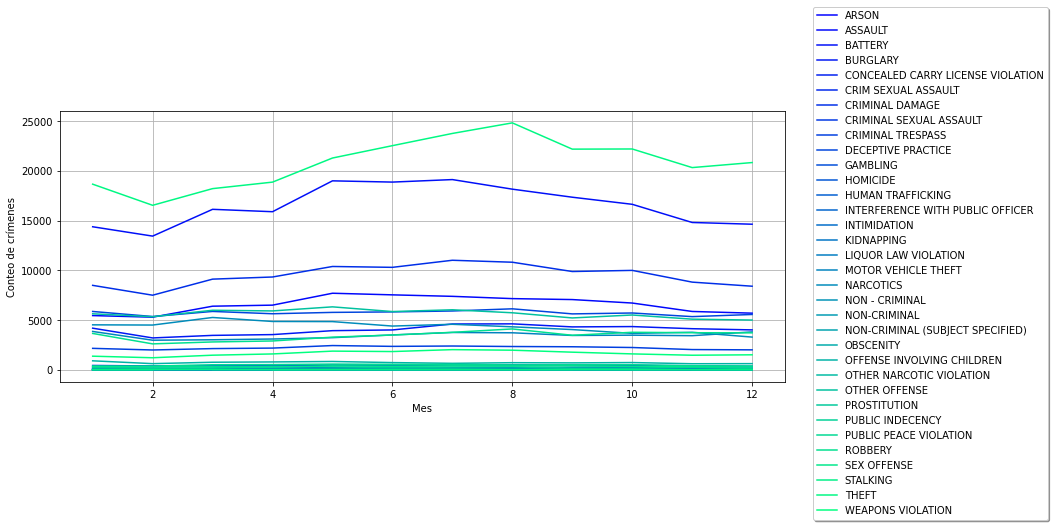

In [ ]:
# Agrupación con gráfica
df_grouped = dfc_16_19.groupby([dfc_16_19.Date.dt.month, 'PrimaryType']).ID.count()
df_grouped.unstack().plot(colormap='winter', grid=True, figsize=(13,5))
plt.xlabel("Mes")
plt.ylabel("Conteo de crímenes")
plt.legend(loc="upper center", bbox_to_anchor=(1.2,1.4), shadow=True, ncol=1)
plt.show()

Al darse un comportameniento ondulatorio de los crimenes para los tres años, la suma de los crímenes por mes en los años analizados muestra los picos mencionados en los meses de julio y agosto.

Una tabla que discrimine esta suma de crimenes por año, separado por meses, se puede realizar de la siguiente forma:

In [ ]:
dfc_16_19.groupby([dfc_16_19.Date.dt.year, dfc_16_19.Date.dt.month, 'PrimaryType'])['ID'].aggregate('count').unstack().fillna(0)

PrimaryType  ARSON  ASSAULT  BATTERY  ...  STALKING   THEFT  WEAPONS VIOLATION
Date Date                             ...                                     
2016 1        42.0   1224.0   3720.0  ...       9.0  4458.0              192.0
     2        31.0   1241.0   3497.0  ...       7.0  3983.0              214.0
     3        41.0   1639.0   4271.0  ...      10.0  4633.0              289.0
     4        46.0   1507.0   4027.0  ...      10.0  4566.0              284.0
     5        55.0   1785.0   4710.0  ...      14.0  5004.0              342.0
     6        41.0   1813.0   4848.0  ...      18.0  5301.0              347.0
     7        47.0   1711.0   4681.0  ...      16.0  5731.0              303.0
     8        45.0   1758.0   4584.0  ...      11.0  5931.0              320.0
     9        45.0   1691.0   4311.0  ...      26.0  5675.0              334.0
     10       51.0   1667.0   4340.0  ...      17.0  5672.0              294.0
     11       34.0   1423.0   3816.0  ...      16.0  5215.0              286.0
     12       37.0   1261.0   3441.0  ...      19.0  4870.0              244.0
2017 1        38.0   1370.0   3563.0  ...      17.0  4906.0              336.0
     2        40.0   1293.0   3410.0  ...      18.0  4375.0              331.0
     3        27.0   1484.0   3856.0  ...      19.0  4461.0              307.0
     4        47.0   1635.0   4099.0  ...      24.0  4765.0              406.0
     5        38.0   1849.0   4557.0  ...      13.0  5295.0              397.0
     6        46.0   1856.0   4643.0  ...      14.0  5719.0              441.0
     7        34.0   1817.0   4698.0  ...      20.0  6040.0              519.0
     8        43.0   1737.0   4417.0  ...      14.0  6387.0              456.0
     9        33.0   1783.0   4389.0  ...      19.0  5452.0              418.0
     10       39.0   1623.0   4156.0  ...      10.0  5646.0              389.0
     11       38.0   1446.0   3710.0  ...       9.0  5297.0              335.0
     12       21.0   1357.0   3640.0  ...       7.0  5241.0              347.0
2018 1        26.0   1414.0   3583.0  ...      15.0  4798.0              410.0
     2        14.0   1350.0   3198.0  ...      12.0  3856.0              306.0
     3        32.0   1618.0   3953.0  ...      15.0  4697.0              393.0
     4        27.0   1639.0   3798.0  ...      17.0  4936.0              399.0
     5        33.0   2032.0   4976.0  ...      24.0  5651.0              541.0
     6        36.0   1875.0   4637.0  ...      17.0  5932.0              497.0
     7        41.0   1940.0   4879.0  ...      25.0  6066.0              547.0
     8        38.0   1841.0   4610.0  ...      15.0  6411.0              561.0
     9        32.0   1810.0   4338.0  ...      12.0  5680.0              486.0
     10       36.0   1710.0   4288.0  ...      15.0  5554.0              451.0
     11       26.0   1538.0   3628.0  ...      15.0  5008.0              405.0
     12       32.0   1575.0   3825.0  ...      17.0  5434.0              448.0
2019 1        22.0   1456.0   3520.0  ...      19.0  4503.0              447.0
     2        28.0   1420.0   3342.0  ...      21.0  4328.0              377.0
     3        28.0   1666.0   4058.0  ...      24.0  4426.0              496.0
     4        31.0   1732.0   3974.0  ...      10.0  4604.0              522.0
     5        25.0   2042.0   4756.0  ...      17.0  5341.0              614.0
     6        29.0   2002.0   4746.0  ...      23.0  5581.0              566.0
     7        45.0   1929.0   4868.0  ...      25.0  5923.0              674.0
     8        36.0   1832.0   4552.0  ...      19.0  6093.0              650.0
     9        29.0   1789.0   4317.0  ...      21.0  5377.0              550.0
     10       30.0   1724.0   3858.0  ...      12.0  5328.0              481.0
     11       32.0   1471.0   3662.0  ...      20.0  4811.0              455.0
     12       40.0   1514.0   3736.0  ...      12.0  5291.0              485.0

[48 rows x 34 columns]

De los valore de la tabla, se ve como, para muchos de los tipos de crímenes, se da un mayor número de casos en julio y agosto.

#####**5. Clasificación de conteos de crímenes por arresto o no**

Realicemos este problema para el caso en que se agrupando por año, mes y tipo de crimen:

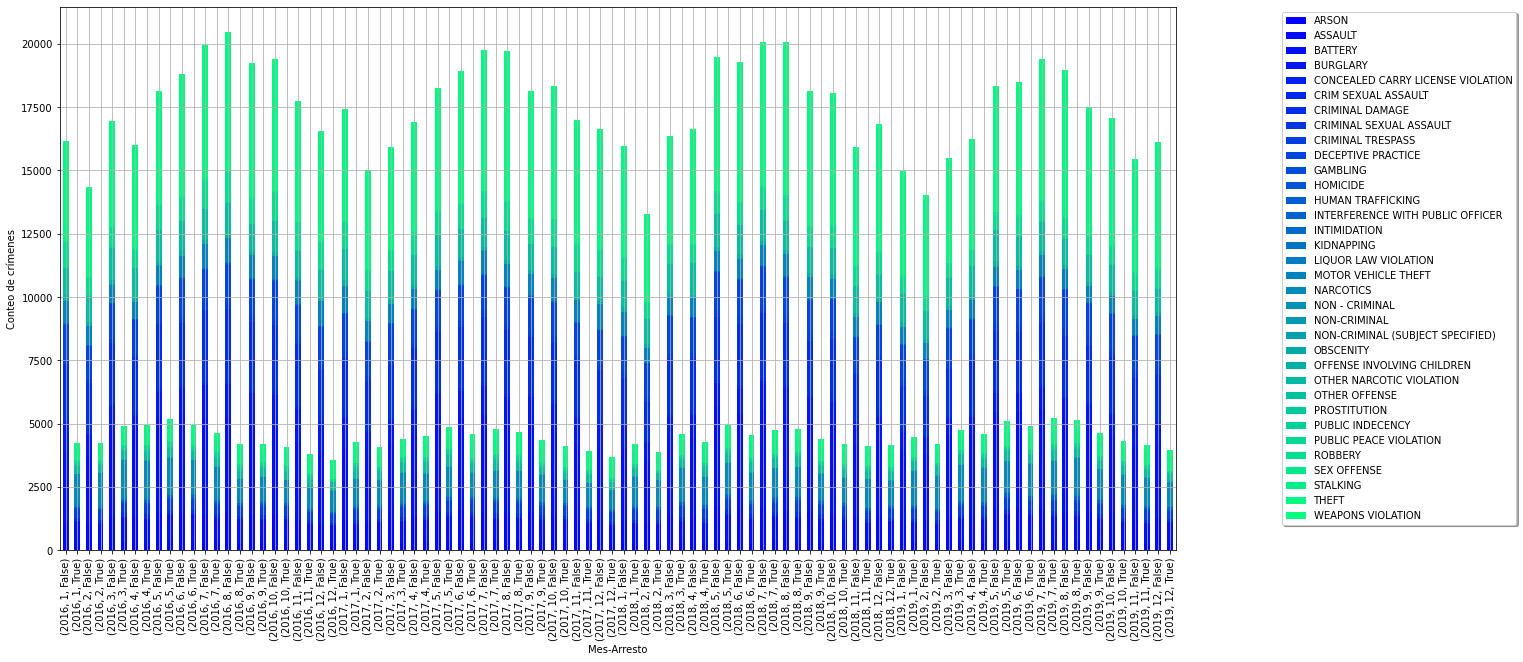

In [ ]:
df_grouped = dfc_16_19.groupby([dfc_16_19.Date.dt.year, dfc_16_19.Date.dt.month,'Arrest','PrimaryType'])['ID'].count()
df_grouped.unstack().plot(kind='bar',stacked=True,  colormap='winter', grid=True, figsize=(20,10))
plt.legend(loc="upper center", bbox_to_anchor=(1.2,1.0), shadow=True, ncol=1)
plt.xlabel("Mes-Arresto")
plt.ylabel("Conteo de crímenes")
plt.show()

Está gráfica nos ilustra como, para los diferentes crímenes cometidos, la mayoría de personas no son arrestadas.

#####**6. Clasificar los 22 distritos en tres categorías (Alta, Media y Baja), de acuerdo con el índice de criminalidad repecto al resto de la ciudad**


**Aclaración:** La tabla no contienen un índice de criminalidad. Podriamos analizar la cantidad de crímenes cometidos por distrito respecto al total de crímenes, es decir, el porcentaje de crímienes por distrito. 

`Seaborn` nos brinda una herramienta sumamente útil para hacer plots de cuentas `countplot`, mendiante la cual podemos ver gráficamente cuales son los distritos donde más crímenes se han cometido en los tres años recogidos:

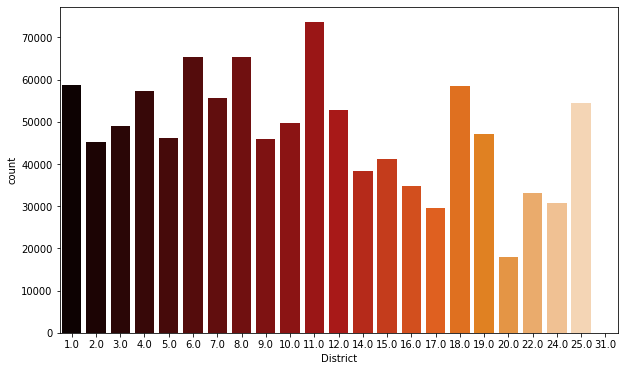

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data = dfc_16_19, x='District', palette='gist_heat')
plt.show()

Esta información puede ser recogida en una tabla de la siguiente forma

In [ ]:
crimes_districs = 100*dfc_16_19.District.value_counts()/len(dfc_16_19)
df_crimes_districts = crimes_districs.reset_index(level=0).rename(columns={"index":"Distrito", "District":"Pocentaje_criminalidad"})
df_crimes_districts

,Distrito,Pocentaje_criminalidad
0,11.0,7.004338
1,6.0,6.225602
2,8.0,6.225507
3,1.0,5.593230
4,18.0,5.560113
5,4.0,5.455812
6,7.0,5.288131
7,25.0,5.178787
8,12.0,5.033279
9,10.0,4.730464


Donde el porcentaje es medido en 3 años.

Vemos entonces como el distrito 11 es en el que se comenten mayores crímenes, seguido de los distritos 6, 8, 1, 18, etc.

Podemos construir una categorización en tres valores del porcentaje de criminalidad: baja, media y alta. Para esto, hacemos lo siguiente

In [ ]:
series = pd.cut(crimes_districs,3, labels=["baja","media","alta"])
series.reset_index(level=0).rename(columns={"index":"Distrito", "District":"Criminalidad"})

,Distrito,Criminalidad
0,11.0,alta
1,6.0,alta
2,8.0,alta
3,1.0,alta
4,18.0,alta
5,4.0,alta
6,7.0,alta
7,25.0,alta
8,12.0,alta
9,10.0,alta


#####**7. Crímenes por distrito**

Resultaría interesante, por ejemplo, analizar dentro de los distritos con más criminalidad, cuales son los tipos de crímenes que más se comente.

Empezamos por agrupar la tabla por crímen y distrito:

In [ ]:
df_DistCrimeCts = dfc_16_19.groupby(['District','PrimaryType']).ID.count().unstack().fillna(0)

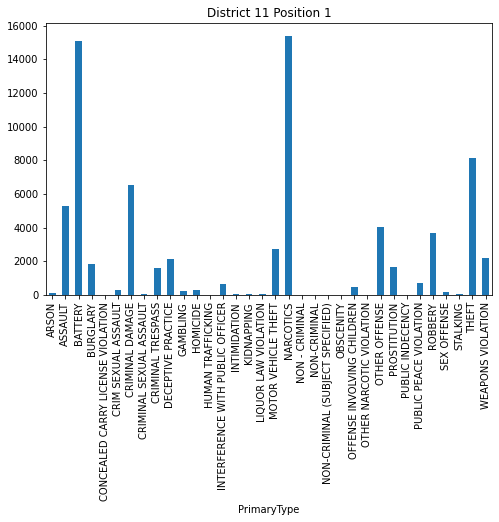

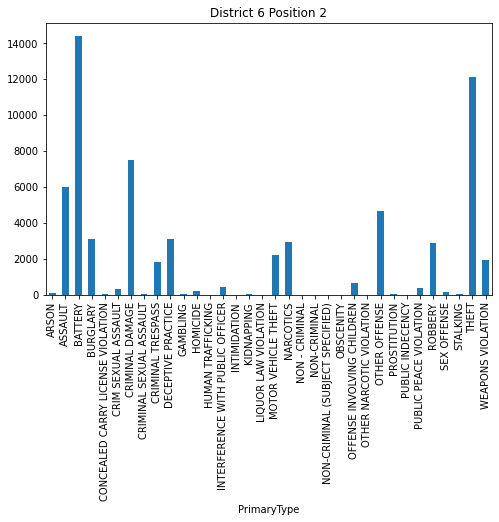

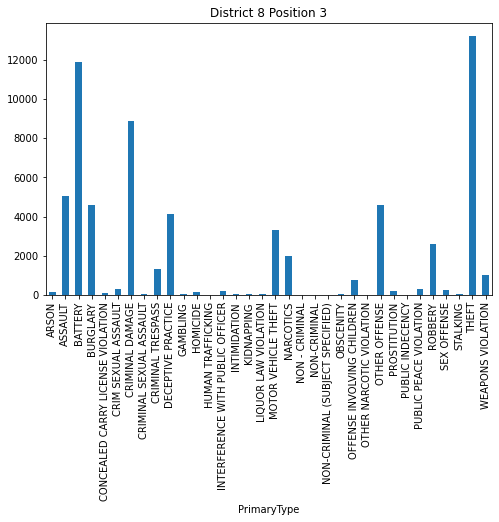

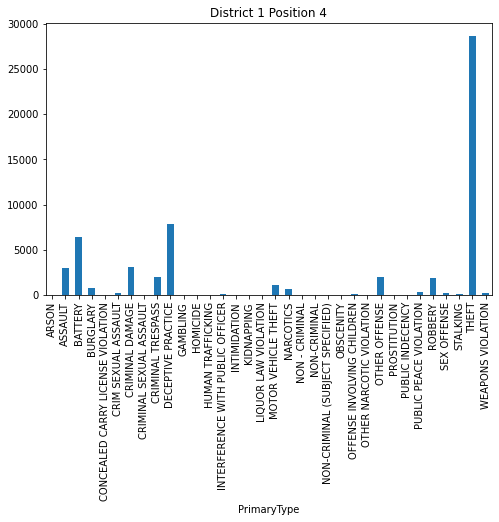

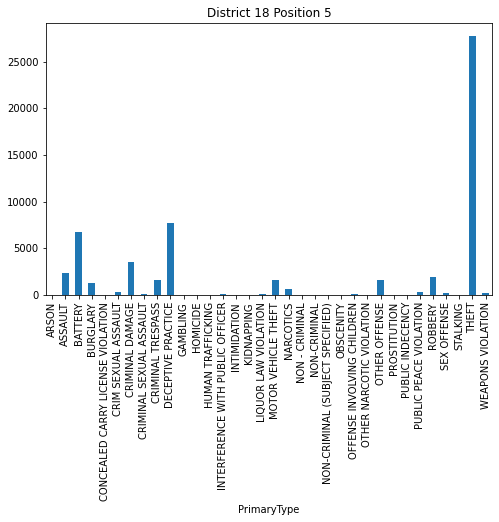

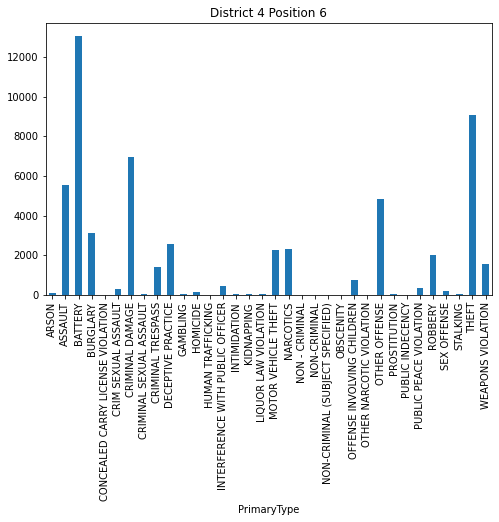

In [ ]:
top_crime = [11, 6, 8, 1, 18, 4]

counter = 1
for i in top_crime:
  plt.figure(figsize=(8,5))
  df_DistCrimeCts.loc[i].plot(kind='bar')
  plt.title("District "+str(i)+" Position "+ str(counter))
  plt.show()
  counter +=1

#**Ejercicio 4:**

Con el dataset Crímenes de chicago, identifique cuales son las 5 principales categorías de crímenes (Primary Type), es decir, cuáles son los crímenes más recurrentes. A cada uno de estos grupos realícele un análisis descriptivo, ejemplo: La mayoría de los crímenes de tipo ASSAULT se cometen en el mes de enero.

##**Desarrollo**

Empecemos por agrupar por del tipo de crímen (Primert Type) y realicemos un conteo para hallar el top 5.

In [ ]:
pd.value_counts(dfc2_16_19.PrimaryType)[:5]

THEFT                 250252
BATTERY               198486
CRIMINAL DAMAGE       114161
ASSAULT                78889
DECEPTIVE PRACTICE     68756
Name: PrimaryType, dtype: int64

Vemos entonces que estos son los 5 crímenes más cometidos:

1. Robo
2. Agresión
3. Daño criminal
4. Asalto
5. Práctica engañosa

###**Conteo de 5 crímenes principales por año, mes, semana y día**

In [ ]:
df_THEFT = dfc2_16_19[dfc2_16_19.PrimaryType=='THEFT'] 
df_BATTERY = dfc2_16_19[dfc2_16_19.PrimaryType=='BATTERY'] 
df_CDAMAGE = dfc2_16_19[dfc2_16_19.PrimaryType=='CRIMINAL DAMAGE']
df_ASSAULT = dfc2_16_19[dfc2_16_19.PrimaryType=='ASSAULT']
df_DPRACTICE = dfc2_16_19[dfc2_16_19.PrimaryType=='DECEPTIVE PRACTICE']

####**Anual**

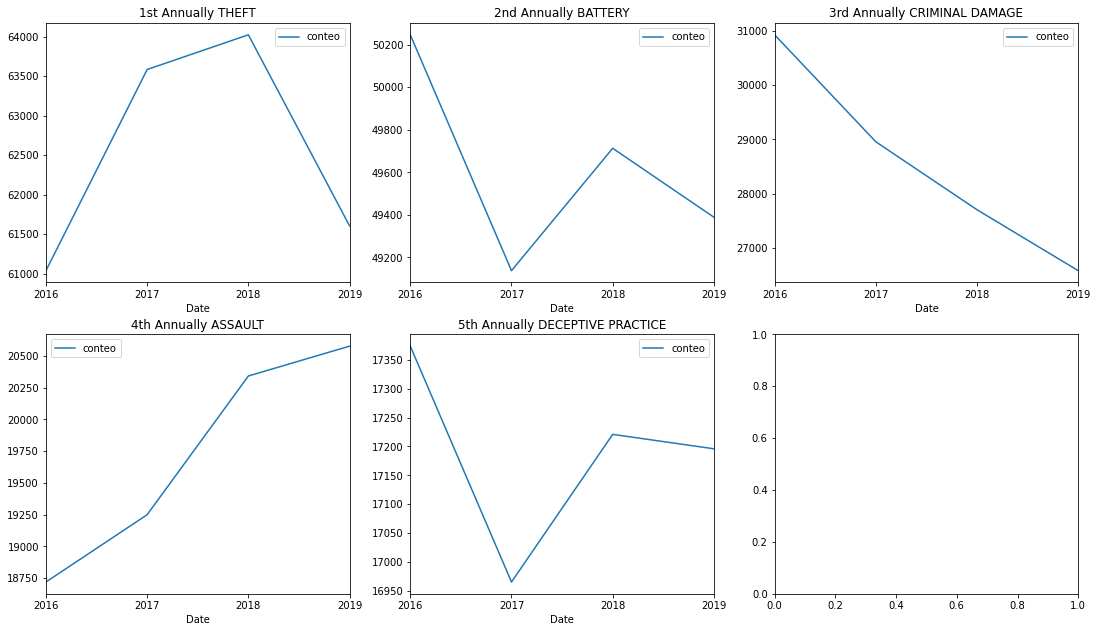

In [ ]:
# Anual
fig, axes = plt.subplots(nrows=2, ncols=3)

df_THEFT[['conteo']].resample('A').sum().plot(ax=axes[0,0], title="1st Annually THEFT")
df_BATTERY[['conteo']].resample('A').sum().plot(ax=axes[0,1], title="2nd Annually BATTERY")
df_CDAMAGE[['conteo']].resample('A').sum().plot(ax=axes[0,2], title="3rd Annually CRIMINAL DAMAGE")
df_ASSAULT[['conteo']].resample('A').sum().plot(ax=axes[1,0], title="4th Annually ASSAULT")
df_DPRACTICE[['conteo']].resample('A').sum().plot(ax=axes[1,1], title="5th Annually DECEPTIVE PRACTICE")
fig.set_size_inches(18.5, 10.5)
plt.show()


**Conclusión:**

Estas gráficas anuales, nos permite ver si hay incrementos o descensos del crimen en cuestión a lo largo de los diferentes años.

De forma genera, el crimen 'CRIMINAL DAMAGE' ha decaido levemente a lo largo de los años analizados y el crimen 'ASSAULT' sufre un leve repunte. El restos de los crímenes cometidos, sufre subidas y bajadas en el conteo.

####**Mensual**

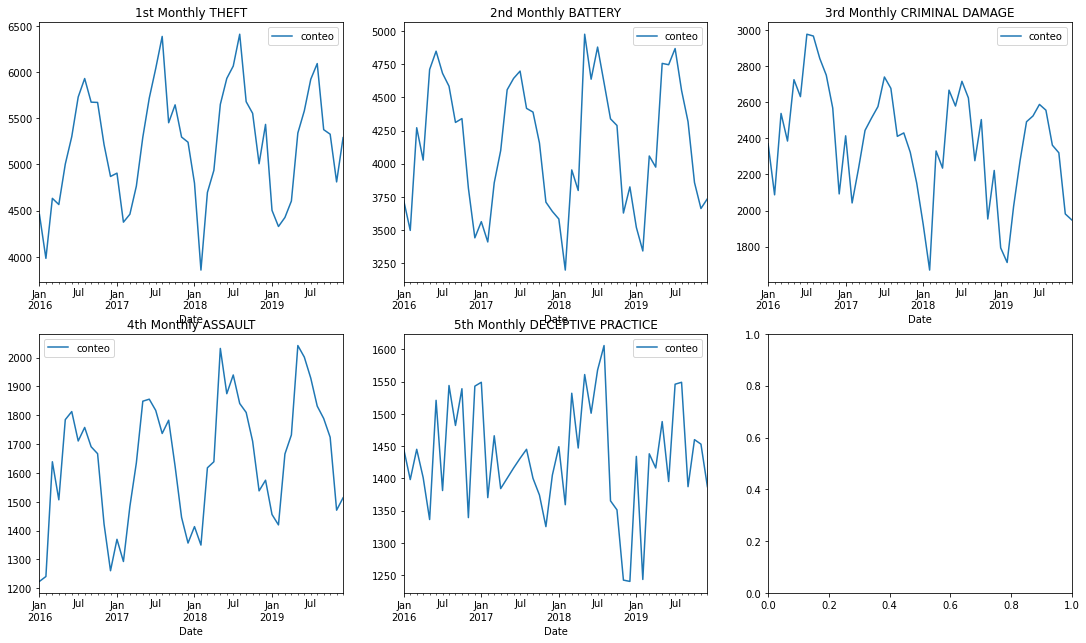

In [ ]:
# Mensual
fig, axes = plt.subplots(nrows=2, ncols=3)

df_THEFT[['conteo']].resample('M').sum().plot(ax=axes[0,0], title="1st Monthly THEFT")
df_BATTERY[['conteo']].resample('M').sum().plot(ax=axes[0,1], title="2nd Monthly BATTERY")
df_CDAMAGE[['conteo']].resample('M').sum().plot(ax=axes[0,2], title="3rd Monthly CRIMINAL DAMAGE")
df_ASSAULT[['conteo']].resample('M').sum().plot(ax=axes[1,0], title="4th Monthly ASSAULT")
df_DPRACTICE[['conteo']].resample('M').sum().plot(ax=axes[1,1], title="5th Monthly DECEPTIVE PRACTICE")
fig.set_size_inches(18.5, 10.5)
plt.show()

**Conclusión:** Todos los crímenes analizados, a excepción del crimen 'DECEPTIVE PRACTICE', presentan un comportamiento oscilatorio, con aumentos marcados entre los meses de Julio y Agosto.

####**Semanal**

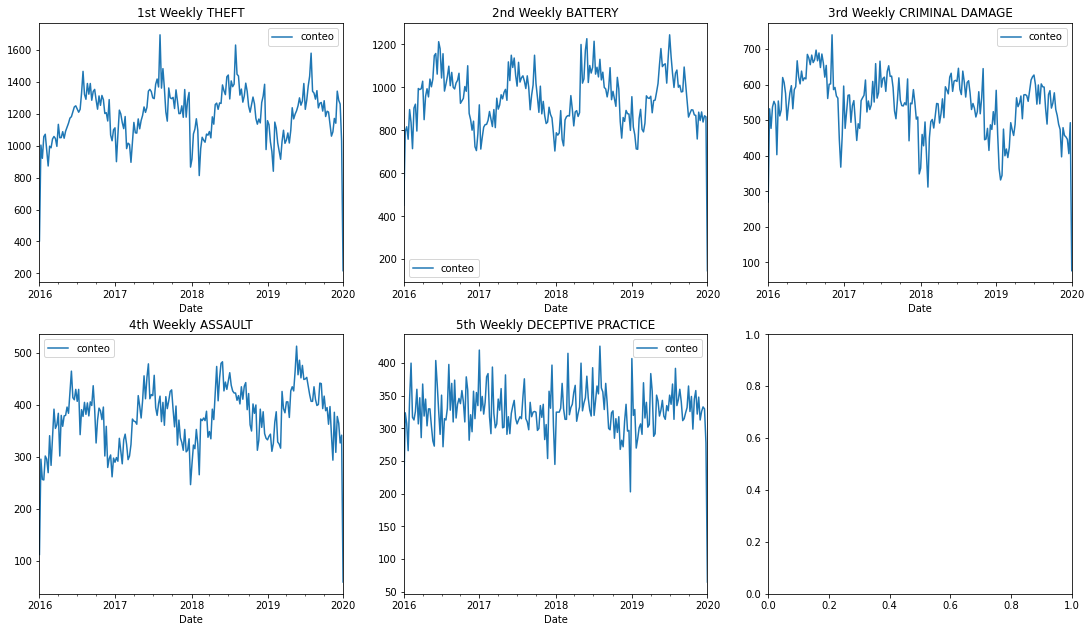

In [ ]:
# Semanal
fig, axes = plt.subplots(nrows=2, ncols=3)

df_THEFT[['conteo']].resample('W').sum().plot(ax=axes[0,0], title="1st Weekly THEFT")
df_BATTERY[['conteo']].resample('W').sum().plot(ax=axes[0,1], title="2nd Weekly BATTERY")
df_CDAMAGE[['conteo']].resample('W').sum().plot(ax=axes[0,2], title="3rd Weekly CRIMINAL DAMAGE")
df_ASSAULT[['conteo']].resample('W').sum().plot(ax=axes[1,0], title="4th Weekly ASSAULT")
df_DPRACTICE[['conteo']].resample('W').sum().plot(ax=axes[1,1], title="5th Weekly DECEPTIVE PRACTICE")
fig.set_size_inches(18.5, 10.5)
plt.show()

**Conclusión:** Todos los crímenes analizados, a excepción del crimen 'DECEPTIVE PRACTICE', presentan un comportamiento  semanal, con aumentos marcados entre los meses de Julio y Agosto.

####**Diario**

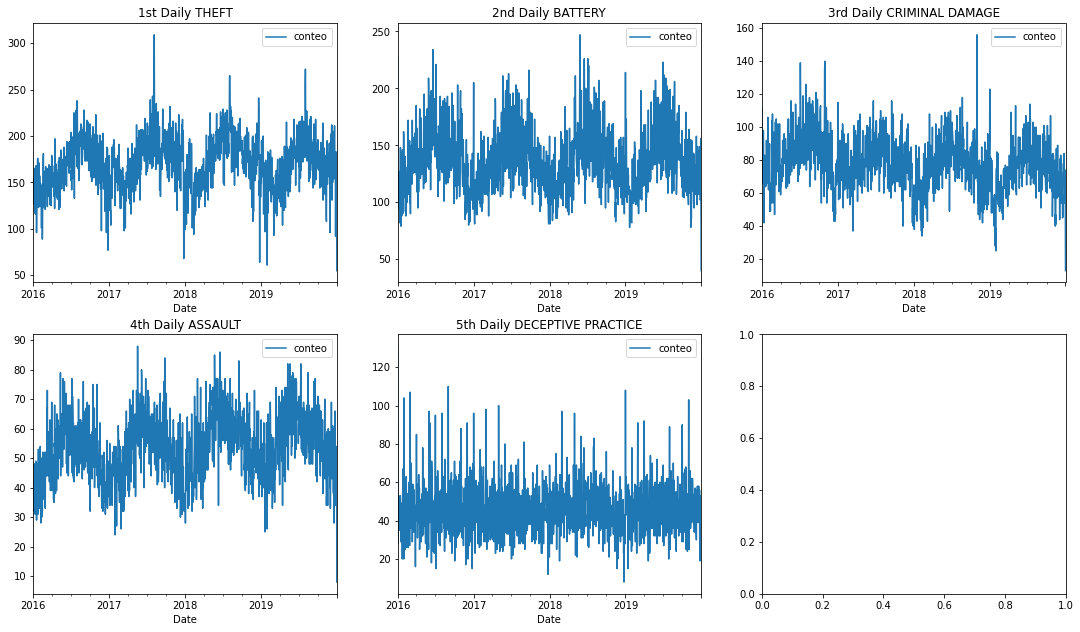

In [ ]:
# Diario
fig, axes = plt.subplots(nrows=2, ncols=3)

df_THEFT[['conteo']].resample('D').sum().plot(ax=axes[0,0], title="1st Daily THEFT")
df_BATTERY[['conteo']].resample('D').sum().plot(ax=axes[0,1], title="2nd Daily BATTERY")
df_CDAMAGE[['conteo']].resample('D').sum().plot(ax=axes[0,2], title="3rd Daily CRIMINAL DAMAGE")
df_ASSAULT[['conteo']].resample('D').sum().plot(ax=axes[1,0], title="4th Daily ASSAULT")
df_DPRACTICE[['conteo']].resample('D').sum().plot(ax=axes[1,1], title="5th Daily DECEPTIVE PRACTICE")
fig.set_size_inches(18.5, 10.5)
plt.show()

**Conclusión:** Todos los crímenes analizados, a excepción del crimen 'DECEPTIVE PRACTICE', presentan un comportamiento oscilatorio diario, con aumentos marcados en Julio y Agosto.

###**Conteo de los 5 crímenes más frecuentes por año y mes: Plot de barras**



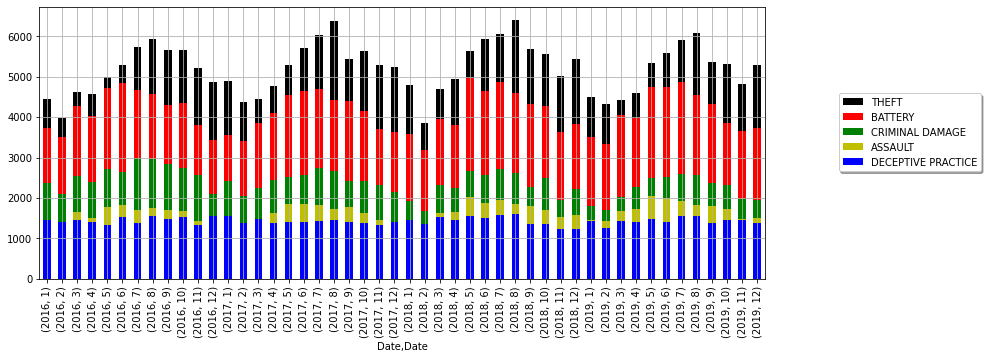

In [ ]:
df_THEFT = dfc_16_19[dfc_16_19.PrimaryType=='THEFT'] 
df_BATTERY = dfc_16_19[dfc_16_19.PrimaryType=='BATTERY'] 
df_CDAMAGE = dfc_16_19[dfc_16_19.PrimaryType=='CRIMINAL DAMAGE']
df_ASSAULT = dfc_16_19[dfc_16_19.PrimaryType=='ASSAULT']
df_DPRACTICE = dfc_16_19[dfc_16_19.PrimaryType=='DECEPTIVE PRACTICE']

plt.figure(figsize=(13,5))

df_THEFT.groupby([dfc_16_19.Date.dt.year, dfc_16_19.Date.dt.month]).ID.count().plot(kind = 'bar', color='k')
df_BATTERY.groupby([dfc_16_19.Date.dt.year, dfc_16_19.Date.dt.month]).ID.count().plot(kind = 'bar', color='r')
df_CDAMAGE.groupby([dfc_16_19.Date.dt.year, dfc_16_19.Date.dt.month]).ID.count().plot(kind = 'bar', color='g')
df_ASSAULT.groupby([dfc_16_19.Date.dt.year, dfc_16_19.Date.dt.month]).ID.count().plot(kind = 'bar', color='y')
df_DPRACTICE.groupby([dfc_16_19.Date.dt.year, dfc_16_19.Date.dt.month]).ID.count().plot(kind = 'bar', color='b')

plt.legend(['THEFT','BATTERY','CRIMINAL DAMAGE','ASSAULT','DECEPTIVE PRACTICE'], loc="upper center", bbox_to_anchor=(1.2,0.7), shadow=True, ncol=1)
plt.grid()
plt.show()

De esta gráfica podemos comentar las siguientes conclusiones, muy en línea con las que habíamos comentado las gráficas de la sección [graficas por tipo, mes y año](#yr_mes_tipo).

En la siguiente tabla se resume los meses en los que se comenten más crimenes por tipo

Crimen | Meses
---|---
THEFT | Julio y Agosto
BATTERY | Junio y Julio
CRIMINAL DAMAGE | Julio y Agosto
ASSAULT | Mayo y Junio
DECEPTIVE PRACTICE | Noviembre y Diciembre



###**Conteo de los 5 crímenes más frecuentes por mes**

Para este caso, solo agropamos por mes y hacemos un conteo en la columna `ID`, por ejemplo:

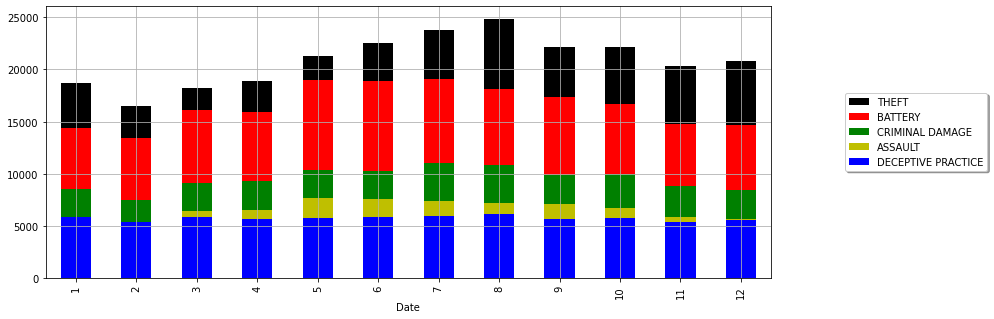

In [ ]:
plt.figure(figsize=(13,5))

df_THEFT.groupby([df_THEFT.Date.dt.month]).ID.count().plot(kind = 'bar', color='k')
df_BATTERY.groupby([df_BATTERY.Date.dt.month]).ID.count().plot(kind = 'bar', color='r')
df_CDAMAGE.groupby([df_CDAMAGE.Date.dt.month]).ID.count().plot(kind = 'bar', color='g')
df_ASSAULT.groupby([df_ASSAULT.Date.dt.month]).ID.count().plot(kind = 'bar', color='y')
df_DPRACTICE.groupby([df_DPRACTICE.Date.dt.month]).ID.count().plot(kind = 'bar', color='b')

plt.legend(['THEFT','BATTERY','CRIMINAL DAMAGE','ASSAULT','DECEPTIVE PRACTICE'], loc="upper center", bbox_to_anchor=(1.2,0.7), shadow=True, ncol=1)
plt.grid()
plt.show()

Las tendencias descritas en a gráfica anterior, se mantienen para esta.

#**Ejercicio 5**
Identifique si con las variables que cuenta es posible predecir la fecha en que se va a realizar un crimen en determinado distrito, en caso de que usted considere que es posible predecirlo indique como lo haría y qué variables usaria (No tiene que modelar la predicción, solo comentar cómo lo haría)

##**Desarrollo:**

En mi opinión, si sería posible predecir la fecha en la que se realizaría un crimen en un determinado distrito, para lo cual implementaría un modelo de redes neuronales en un arquitectura de tipo LSTM. Este modelo aprende una función que mapea una serie temporal de eventos en un tiempo pasado a una ventana temporal futura, por ejemplo.  Los pasos comprendidos son los siguientes:

1. Tomamos las series de tiempo de crimenes agrupadas por cada distrito ("características a construir").
2. Dividimos cada serie de tiempo (representada por cada distrito) en varias ventanas temporales que pueden solaparse entre sí. Por ejemplo:
  - De la semana 1 a 4 de enero de 2016
  - De la semana 2 de enero a la 1 de febrero
  - etc

3. Por  cada una de estas ventanas tendremos una ventana temporal desplazada y más pequeña que actuará como "la etiqueta" que es aprendida para predecir el siguiente valor en la secuencia.

4. La red es alimentada con los datos preparados en los pasos 1 a 3.

De esta forma podríamos construir un modelo que aprenda a predecir la fecha por distrito en la que se realizará un crimen. 

El punto pregunta por las caractarísticas que usaría. En este caso, las "características" serían las series de tiempo de lo crímenes por distrito, las cuales podrían extraerse fácilmente del dataset con el método de `resample()` o agrupando por fechas y distritos.
